In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

import matplotlib.cm as cm
from matplotlib.colors import LogNorm

Evaluating round 0 (../build/repeated_fake_3d/stats_0.bag)...
Evaluating round 1 (../build/repeated_fake_3d/stats_1.bag)...
Evaluating round 2 (../build/repeated_fake_3d/stats_2.bag)...
Evaluating round 3 (../build/repeated_fake_3d/stats_3.bag)...
Evaluating round 4 (../build/repeated_fake_3d/stats_4.bag)...
Evaluating round 5 (../build/repeated_fake_3d/stats_5.bag)...
Evaluating round 6 (../build/repeated_fake_3d/stats_6.bag)...
Evaluating round 7 (../build/repeated_fake_3d/stats_7.bag)...
Evaluating round 8 (../build/repeated_fake_3d/stats_8.bag)...
Evaluating round 9 (../build/repeated_fake_3d/stats_9.bag)...


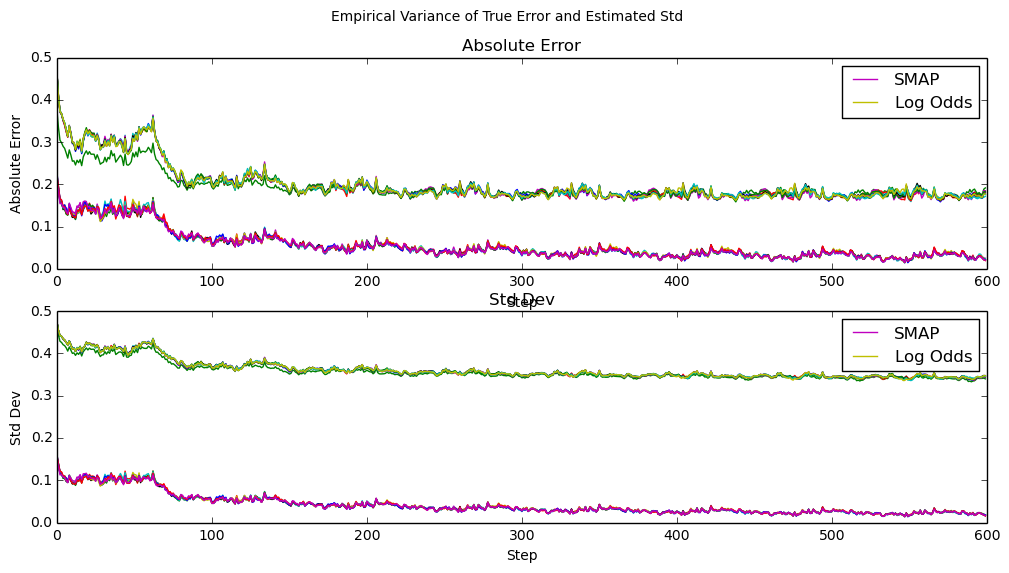

In [5]:
%matplotlib inline
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(12, 6))
fig.suptitle("Empirical Variance of True Error and Estimated Std")

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.2f %.2f %.2f" % (x, y, z)

filenames = sorted(
    glob.glob("../build/repeated_fake_3d/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("../build/repeated_fake_3d/"):])[0]))

for rnd, filename in enumerate(filenames):
    print "Evaluating round %i (%s)..." % (rnd, filename)
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
        
    steps = stats.step
    
    updated_voxels_step = []
    start = 0
    for step in range(stats.step):
        step_voxels = []
        for voxel in range(stats.updatedVoxels[step]):
            step_voxels.append((voxel, hash_position(stats.updatedVoxelsX[start + voxel],
                                             stats.updatedVoxelsY[start + voxel],
                                             stats.updatedVoxelsX[start + voxel])))
        updated_voxels_step.append(step_voxels)
        start += stats.updatedVoxels[step]
    updated_voxels.append(updated_voxels_step)    
        
    start = 0
    err0sBelief = []
    err0sLogOdds = []
    std0sBelief = []
    std0sLogOdds = []
    
    err_belief_rnd = []
    std_belief_rnd = []
    err_logodds_rnd = []
    std_logodds_rnd = []
    
    for step in range(stats.step):
        err_belief_rnd.append(np.array(stats.errorCompleteUpdatedBelief[start:start + stats.updatedVoxels[step]]))
        std_belief_rnd.append(np.array(stats.stdCompleteUpdatedBelief[start:start + stats.updatedVoxels[step]]))
        err_logodds_rnd.append(np.array(stats.errorCompleteUpdatedLogOdds[start:start + stats.updatedVoxels[step]]))
        std_logodds_rnd.append(np.array(stats.stdCompleteUpdatedLogOdds[start:start + stats.updatedVoxels[step]]))
        
        err0Belief = np.mean(err_belief_rnd[-1])
        err0sBelief.append(err0Belief)
        err0LogOdds = np.mean(err_logodds_rnd[-1])
        err0sLogOdds.append(err0LogOdds)
        
        std0Belief = np.mean(std_belief_rnd[-1])
        std0sBelief.append(std0Belief)
        std0LogOdds = np.mean(std_logodds_rnd[-1])
        std0sLogOdds.append(std0LogOdds)
        
        start += stats.updatedVoxels[step]
        
    err_belief.append(err_belief_rnd)
    std_belief.append(std_belief_rnd)
    err_logodds.append(err_logodds_rnd)
    std_logodds.append(std_logodds_rnd)
        
    #ax3.plot(stats.updatedVoxels)
        
    if rnd == len(filenames) - 1:
        ax1.plot(err0sBelief, label="SMAP")
        ax1.plot(err0sLogOdds, label="Log Odds")
    else:
        ax1.plot(err0sBelief, label="_nolegend_")
        ax1.plot(err0sLogOdds, label="_nolegend_")        
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Absolute Error")
    ax1.set_title("Absolute Error")
    
    if rnd == len(filenames) - 1:
        ax2.plot(std0sBelief, label="SMAP")
        ax2.plot(std0sLogOdds, label="Log Odds")
    else:
        ax2.plot(std0sBelief, label="_nolegend_")
        ax2.plot(std0sLogOdds, label="_nolegend_")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Std Dev")
    ax2.set_title("Std Dev")
    
ax1.legend()
ax2.legend()

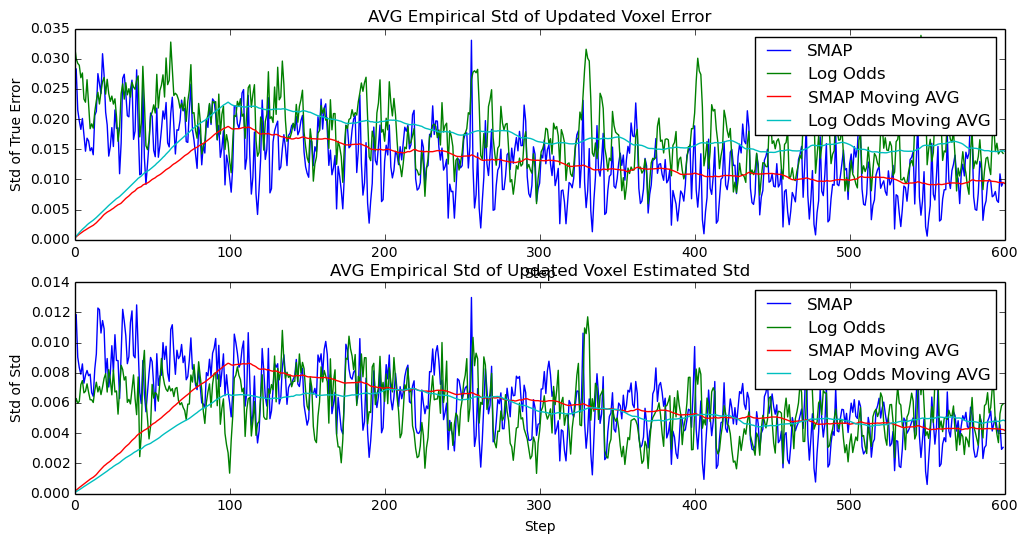

In [6]:
%matplotlib inline
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(12, 6))
var_err_belief = []
var_std_belief = []
var_err_logodds = []
var_std_logodds = []
for step in range(steps):
    updated = [updated_voxels[rnd][step] for rnd in range(len(filenames))]
    positions = [map(lambda x: x[1], vs) for vs in updated]
    unique = reduce(set.intersection, map(set, positions))
    indices = [[x[0] for x in vs if x[1] in unique] for vs in updated]
    
#     print "step:", step, " \tunique:", len(unique), " \tupdated:", len(updated[0])
    
#     if step == 100 or step == 200:
# #         print "updated:  ", updated
#         print "\n\n\n", step
#         print "positions:", positions
#         print "\n\n\n", step
#         print "unique:   ", unique
#         print "indices:  ", indices
    
    var_err_step_belief = []
    var_std_step_belief = []
    var_err_step_logodds = []
    var_std_step_logodds = []
    for voxeli in range(len(unique)):
        err_step_voxeli_belief = np.array([err_belief[rnd][step][indices[rnd][voxeli]] for rnd in range(len(filenames))])
        std_step_voxeli_belief = np.array([std_belief[rnd][step][indices[rnd][voxeli]] for rnd in range(len(filenames))])
        var_err_step_belief.append(np.std(err_step_voxeli_belief))
        var_std_step_belief.append(np.std(std_step_voxeli_belief))
        err_step_voxeli_logodds = np.array([err_logodds[rnd][step][indices[rnd][voxeli]] for rnd in range(len(filenames))])
        std_step_voxeli_logodds = np.array([std_logodds[rnd][step][indices[rnd][voxeli]] for rnd in range(len(filenames))])
        var_err_step_logodds.append(np.std(err_step_voxeli_logodds))
        var_std_step_logodds.append(np.std(std_step_voxeli_logodds))
        
    var_err_belief.append(np.mean(np.array(var_err_step_belief)))
    var_std_belief.append(np.mean(np.array(var_std_step_belief)))
    var_err_logodds.append(np.mean(np.array(var_err_step_logodds)))
    var_std_logodds.append(np.mean(np.array(var_std_step_logodds)))
    
def moving_average(array, n=100):
    return np.convolve(array, np.ones(n) / n)
    
ax1.plot(var_err_belief, label="SMAP")
ax1.plot(var_err_logodds, label="Log Odds")
ax1.plot(moving_average(var_err_belief), label="SMAP Moving AVG")
ax1.plot(moving_average(var_err_logodds), label="Log Odds Moving AVG")
ax1.set_xlabel("Step")
ax1.set_ylabel("Std of True Error")
ax1.set_xlim([0, steps])
ax1.legend()
ax1.set_title("AVG Empirical Std of Updated Voxel Error")

ax2.plot(var_std_belief, label="SMAP")
ax2.plot(var_std_logodds, label="Log Odds")
ax2.plot(moving_average(var_std_belief), label="SMAP Moving AVG")
ax2.plot(moving_average(var_std_logodds), label="Log Odds Moving AVG")
ax2.set_xlabel("Step")
ax2.set_ylabel("Std of Std")
ax2.set_xlim([0, steps])
ax2.legend()
ax2.set_title("AVG Empirical Std of Updated Voxel Estimated Std")

Evaluating round 0 (../build/repeated_fake_3d/stats_0.bag)...
Evaluating round 1 (../build/repeated_fake_3d/stats_1.bag)...
Evaluating round 2 (../build/repeated_fake_3d/stats_2.bag)...
Evaluating round 3 (../build/repeated_fake_3d/stats_3.bag)...
Evaluating round 4 (../build/repeated_fake_3d/stats_4.bag)...
Evaluating round 5 (../build/repeated_fake_3d/stats_5.bag)...
Evaluating round 6 (../build/repeated_fake_3d/stats_6.bag)...
Evaluating round 7 (../build/repeated_fake_3d/stats_7.bag)...
Evaluating round 8 (../build/repeated_fake_3d/stats_8.bag)...
Evaluating round 9 (../build/repeated_fake_3d/stats_9.bag)...


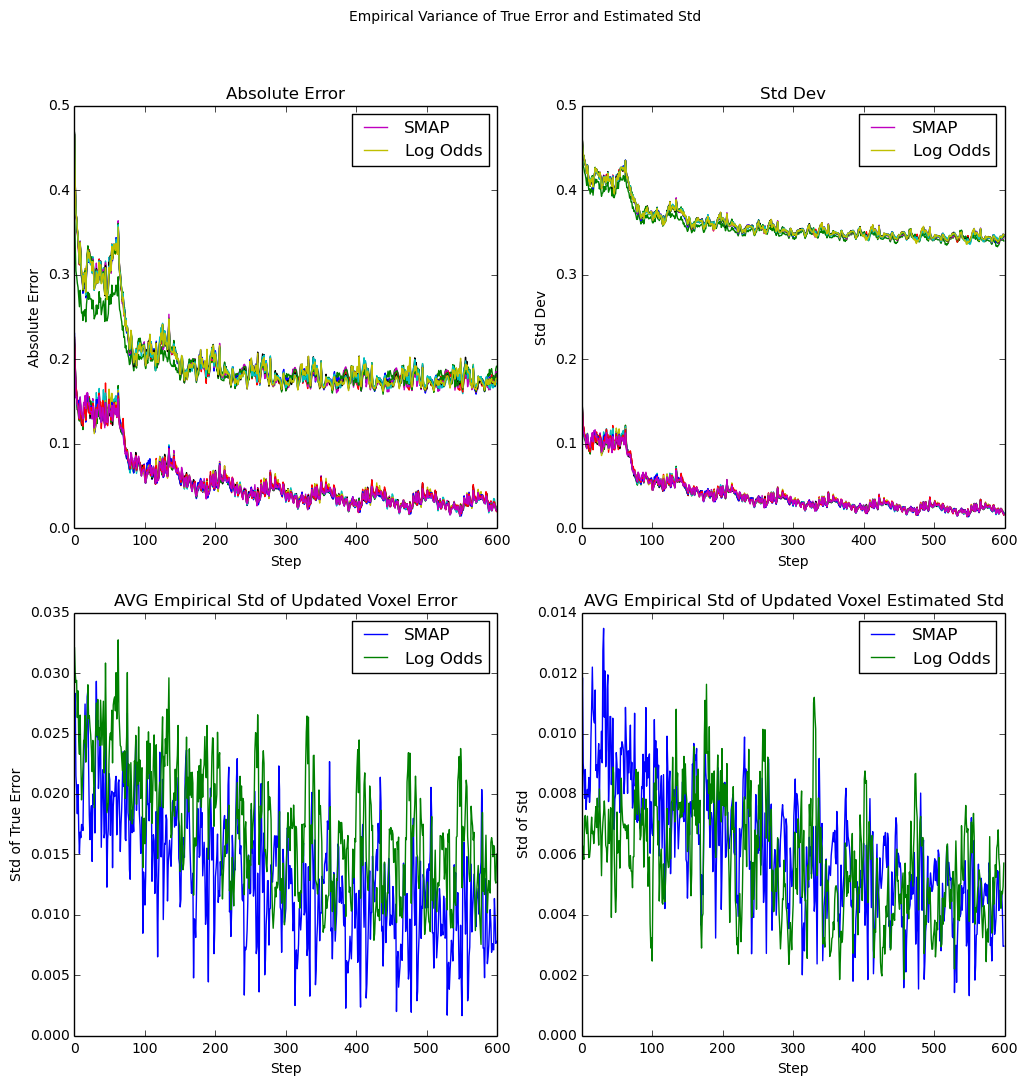

In [4]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Empirical Variance of True Error and Estimated Std")

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("../build/repeated_fake_3d/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("../build/repeated_fake_3d/"):])[0]))

for rnd, filename in enumerate(filenames):
    print "Evaluating round %i (%s)..." % (rnd, filename)
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
        
    steps = stats.step
    
    updated_voxels_step = []
    for step in range(stats.step):
        step_voxels = []
        for voxel in range(stats.updatedVoxels[step]):
            step_voxels.append((voxel, hash_position(stats.updatedVoxelsX[voxel],
                                             stats.updatedVoxelsY[voxel],
                                             stats.updatedVoxelsX[voxel])))
        updated_voxels_step.append(step_voxels)
    updated_voxels.append(updated_voxels_step)    
        
    start = 0
    err0sBelief = []
    err0sLogOdds = []
    std0sBelief = []
    std0sLogOdds = []
    
    err_belief_rnd = []
    std_belief_rnd = []
    err_logodds_rnd = []
    std_logodds_rnd = []
    
    for step in range(stats.step):
        err_belief_rnd.append(np.array(stats.errorCompleteUpdatedBelief[start:start + stats.updatedVoxels[step]]))
        std_belief_rnd.append(np.array(stats.stdCompleteUpdatedBelief[start:start + stats.updatedVoxels[step]]))
        err_logodds_rnd.append(np.array(stats.errorCompleteUpdatedLogOdds[start:start + stats.updatedVoxels[step]]))
        std_logodds_rnd.append(np.array(stats.stdCompleteUpdatedLogOdds[start:start + stats.updatedVoxels[step]]))
        
        err0Belief = np.mean(err_belief_rnd[-1])
        err0sBelief.append(err0Belief)
        err0LogOdds = np.mean(err_logodds_rnd[-1])
        err0sLogOdds.append(err0LogOdds)
        
        std0Belief = np.mean(std_belief_rnd[-1])
        std0sBelief.append(std0Belief)
        std0LogOdds = np.mean(std_logodds_rnd[-1])
        std0sLogOdds.append(std0LogOdds)
        
        start += stats.updatedVoxels[step]
        
    err_belief.append(err_belief_rnd)
    std_belief.append(std_belief_rnd)
    err_logodds.append(err_logodds_rnd)
    std_logodds.append(std_logodds_rnd)
        
    #ax3.plot(stats.updatedVoxels)
        
    if rnd == len(filenames) - 1:
        ax1.plot(err0sBelief, label="SMAP")
        ax1.plot(err0sLogOdds, label="Log Odds")
    else:
        ax1.plot(err0sBelief, label="_nolegend_")
        ax1.plot(err0sLogOdds, label="_nolegend_")        
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Absolute Error")
    ax1.set_title("Absolute Error")
    
    if rnd == len(filenames) - 1:
        ax2.plot(std0sBelief, label="SMAP")
        ax2.plot(std0sLogOdds, label="Log Odds")
    else:
        ax2.plot(std0sBelief, label="_nolegend_")
        ax2.plot(std0sLogOdds, label="_nolegend_")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Std Dev")
    ax2.set_title("Std Dev")
    
ax1.legend()
ax2.legend()
    
var_err_belief = []
var_std_belief = []
var_err_logodds = []
var_std_logodds = []
for step in range(steps):
    updated = [updated_voxels[rnd][step] for rnd in range(len(filenames))]
    positions = [map(lambda x: x[1], vs) for vs in updated]
    unique = reduce(set.intersection, map(set, positions))
    indices = [[x[0] for x in vs if x[1] in unique] for vs in updated]
    
#     if step == 100:
#         print "updated:  ", updated
#         print "positions:", positions
#         print "unique:   ", unique
#         print "indices:  ", indices
    
    var_err_step_belief = []
    var_std_step_belief = []
    var_err_step_logodds = []
    var_std_step_logodds = []
    for voxeli in range(len(unique)):
        err_step_voxeli_belief = np.array([err_belief[rnd][step][indices[rnd][voxeli]] for rnd in range(len(filenames))])
        std_step_voxeli_belief = np.array([std_belief[rnd][step][indices[rnd][voxeli]] for rnd in range(len(filenames))])
        var_err_step_belief.append(np.std(err_step_voxeli_belief))
        var_std_step_belief.append(np.std(std_step_voxeli_belief))
        err_step_voxeli_logodds = np.array([err_logodds[rnd][step][indices[rnd][voxeli]] for rnd in range(len(filenames))])
        std_step_voxeli_logodds = np.array([std_logodds[rnd][step][indices[rnd][voxeli]] for rnd in range(len(filenames))])
        var_err_step_logodds.append(np.std(err_step_voxeli_logodds))
        var_std_step_logodds.append(np.std(std_step_voxeli_logodds))
        
    var_err_belief.append(np.mean(np.array(var_err_step_belief)))
    var_std_belief.append(np.mean(np.array(var_std_step_belief)))
    var_err_logodds.append(np.mean(np.array(var_err_step_logodds)))
    var_std_logodds.append(np.mean(np.array(var_std_step_logodds)))
    
def moving_average(array, n=10):
    return np.convolve(array, np.ones(n) / n)
    
ax3.plot(var_err_belief, label="SMAP")
ax3.plot(var_err_logodds, label="Log Odds")
# ax3.plot(moving_average(var_err_belief), label="SMAP Moving AVG")
# ax3.plot(moving_average(var_err_logodds), label="Log Odds Moving AVG")
ax3.set_xlabel("Step")
ax3.set_ylabel("Std of True Error")
ax3.set_xlim([0, steps])
ax3.legend()
ax3.set_title("AVG Empirical Std of Updated Voxel Error")

ax4.plot(var_std_belief, label="SMAP")
ax4.plot(var_std_logodds, label="Log Odds")
# ax4.plot(moving_average(var_std_belief), label="SMAP Moving AVG")
# ax4.plot(moving_average(var_std_logodds), label="Log Odds Moving AVG")
ax4.set_xlabel("Step")
ax4.set_ylabel("Std of Std")
ax4.set_xlim([0, steps])
ax4.legend()
ax4.set_title("AVG Empirical Std of Updated Voxel Estimated Std")